# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

In [8]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [17]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
tar: Error opening archive: Failed to open 'VOCtrainval_11-May-2012.tar'


In [ ]:
!pip install scipy==1.1.0

^C


### 1.1 Loading the dataset

In [3]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [4]:
import torch.nn as nn

class Segnet(nn.Module):
    # TODO: Dropout-Layer
    #       Recurrent U-Net
    #       Batch-Normalization
    
    # Upsample works with "minibatch x channels x height x width"-tensors
  
    def __init__(self, num_classes=21, weights=None):
        """
        @param num_classes: number of classes to distinguish
        @param weights: file with old weights for this network as a warm start to not relearn all the weights again
        """
        super(Segnet, self).__init__()
        
        self.num_classes = num_classes

        # input channels, output channels, kernel_size
        self.d_conv11 = nn.Conv2d(3, 16, 3, padding=1)
        self.d_conv12 = nn.Conv2d(16, 16, 3, padding=1)
        self.d_conv21 = nn.Conv2d(16, 32, 3, padding=1)
        self.d_conv22 = nn.Conv2d(32, 32, 3, padding=1)
        self.d_conv31 = nn.Conv2d(32, 64, 3, padding=1)
        self.d_conv32 = nn.Conv2d(64, 64, 3, padding=1)
        self.d_conv41 = nn.Conv2d(64, 128, 3, padding=1)
        self.d_conv42 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.b_conv51 = nn.Conv2d(128, 256, 3, padding=1)
        self.b_conv52 = nn.Conv2d(256, 256, 3, padding=1)
        
        self.u_conv41 = nn.Conv2d(256, 128, 3, padding=1)
        self.u_conv42 = nn.Conv2d(256, 128, 3, padding=1)
        self.u_conv31 = nn.Conv2d(128, 64, 3, padding=1)
        self.u_conv32 = nn.Conv2d(128, 64, 3, padding=1)
        self.u_conv21 = nn.Conv2d(64, 32, 3, padding=1)
        self.u_conv22 = nn.Conv2d(64, 32, 3, padding=1)
        self.u_conv11 = nn.Conv2d(32, 16, 3, padding=1)
        self.u_conv12 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.o_conv01 = nn.Conv2d(16, 16, 3, padding=1)
        self.o_conv02 = nn.Conv2d(16, self.num_classes, 3, padding=1)
        
        if weights is not None:
            self.load(weights)
  
    def forward(self, x):
        # dimensionality comments are given as width x height x channels,
        # nevertheless, the input should be channels first!!!
        
        # x = 512x512x3
        x = self.d_conv11(x)
        x = nn.ReLU()(x)

        # x = 512x512x16
        x1 = self.d_conv12(x)
        x = nn.MaxPool2d(2)(x1)
        x = nn.ReLU()(x)

        # x = 256x256x16
        x = self.d_conv21(x)
        x = nn.ReLU()(x)

        # x = 256x256x32
        x2 = self.d_conv22(x)
        x = nn.MaxPool2d(2)(x2)
        x = nn.ReLU()(x)

        # x = 128x128x32
        x = self.d_conv31(x)
        x = nn.ReLU()(x)

        # x = 128x128x64
        x3 = self.d_conv32(x)
        x = nn.MaxPool2d(2)(x3)
        x = nn.ReLU()(x)

        # x = 64x64x64
        x = self.d_conv41(x)
        x = nn.ReLU()(x)

        # x = 64x64x128
        x4 = self.d_conv42(x)
        x = nn.MaxPool2d(2)(x4)
        x = nn.ReLU()(x)

        # x = 32x32x128
        x = self.b_conv51(x)
        x = nn.ReLU()(x)
        
        # x = 32x32x256
        x = self.b_conv52(x)
        x = nn.ReLU()(x)
        
        # x = 32x32x256
        x = nn.Upsample(scale_factor=2)(x)
        # x = 64x64x256
        x = self.u_conv41(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x4), dim=1)
        x = self.u_conv41(x)
        x = nn.ReLU()(x)
        
        # x = 64x64x128
        x = nn.Upsample(scale_factor=2)(x)
        # x = 128x128x128
        x = self.u_conv31(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x3), dim=1)
        x = self.u_conv32(x)
        x = nn.ReLU()(x)
        
        # x = 128x128x64
        x = nn.Upsample(scale_factor=2)(x)
        # x = 256x256x64
        x = self.u_conv21(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x2), dim=1)
        x = self.u_conv22(x)
        x = nn.ReLU()(x)
        
        # x = 256x256x32
        x = nn.Upsample(scale_factor=2)(x)
        # x = 512x512x32
        x = self.u_conv11(x)
        x = nn.ReLU()(x)
        x = torch.cat((x, x1), dim=1)
        x = self.u_conv12(x)
        x = nn.ReLU()(x)
        
        x = self.o_conv01(x)
        x = nn.ReLU()(x)
        x = self.o_conv02(x)
        x = nn.Softmax(dim=1)(x)
        
        return x
    
    def classify(self, x):
        return self.forward(x).argmax(dim=1)
    
    def save(self, file_name):
        torch.save(self.state_dict(), file_name)
    
    def load(self, file_name):
        self.load_state_dict(torch.load(file_name))

In [5]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
model = Segnet().to(device)
print("Model has", sum(p.numel() for p in model.parameters() if p.requires_grad), "parameters")

Model has 1967973 parameters


### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [6]:
project_root_dir = "/content/drive/My Drive/Project"  # modify it according to your device
local_path = project_root_dir + '/data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012/'
batch_size = 16
epochs = 3

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [9]:
# dataset variable
# this step takes once around 15 minutes to create the masks
dst = pascalVOCDataset(root=local_path, is_transform=True)

# dataloader variable
trainloader = data.DataLoader(dst, batch_size=batch_size, shuffle=True)

KeyboardInterrupt: ignored

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [ ]:
# loss function
# as this is a classification task, the CrossEntropyLoss an appropriate choice
loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [ ]:
# some general statistics
episode_losses = []
episode_losses_detail = []

for e in range(epochs):
    
    # some episode statistics
    episode_loss = 0
    episode_loss_detail = []
    
    for i, d in enumerate(trainloader):
        
        # forwarding the data through the network and compute the loss
        output = model.forward(d[0].to(device))
        loss = loss_f(output, d[1].to(device))
        
        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # doing some statistics
        loss = loss.item()
        episode_loss += loss
        episode_loss_detail.append(loss)
        print("\rEpisode", e + 1, "/", epochs, "- Batch", i + 1, "/", len(dst)//batch_size, "\tLoss:", loss, end="")
    
    # update the general statistics
    episode_losses.append(episode_loss)
    episode_losses_detail.append(episode_loss_detail)

    # save the models weights
    model.save(F"{project_root_dir}/weights/network_epoch{e}.pth")

# save lines!
f = open(project_root_dir + "/weights/losses.csv", "w")
f.write(",".join([str(l) for l in episode_losses]) + "\n")
for line in episode_losses_detail:
    f.write(",".join([str(l) for l in line]) + "\n")

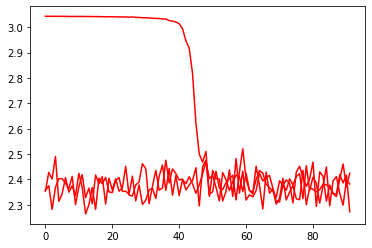

In [41]:
import matplotlib.pyplot as plt

for i, line in enumerate(episode_losses_detail):
    plt.plot(line, label=F"Episode: {i + 1}", c="red")

plt.show()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [83]:
from sklearn.metrics import roc_auc_score as roc, confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion(matrix, num_classes=21):
    df_cm = pd.DataFrame(matrix, range(num_classes), range(num_classes))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm) # font size
    plt.show()

def evaluate(ground_truth, predictions, num_classes=21):
    f1_score, auc_score, dice_coefficient = 0, 0, 0
    for gt, p in zip(ground_truth, predictions):
        # compute confusion matrix
        y_true = gt.view(512*512)
        y_pred = p.view(512*512)
        matrix = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        
        true_positives, precisions, recalls = [], [], []
        # compute true recall and precision
        for i in range(num_classes):
            true_positives.append(matrix[i, i])

            # compute the sum of the true number of pixels of the class
            tpfn = sum(matrix[j, i] for j in range(num_classes))

            # compute the sum of the predicted number of pixels of the class
            tpfp = sum(matrix[i, j] for j in range(num_classes))

            # only take those into account that can really count, 
            # i.e. truth or prediction use this class
            if tpfn != 0 or tpfp != 0:
                precisions.append(0 if tpfn == 0 else matrix[i, i] / tpfn)
                recalls.append(0 if tpfp == 0 else matrix[i, i] / tpfp)
        
        # normalize and compute the f1_score
        precision = sum(precisions) / len(precisions)
        recall = sum(recalls) / len(recalls)
        
        f1_score += 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
        
        # auc_score += auc(gt, p)
        print(sum(true_positives), "|", sum(sum(matrix)))
        dice_coefficient += sum(true_positives) / sum(sum(matrix))
    return f1_score / len(ground_truth), auc_score / len(ground_truth), dice_coefficient / len(ground_truth)

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

194045 | 262144
231276 | 262144
261227 | 262144


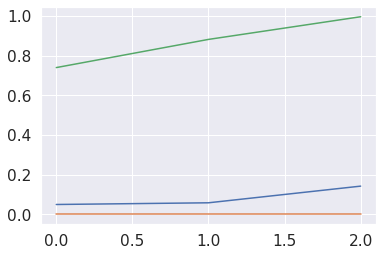

In [84]:
# dataset variable
# this step takes once around 15 minutes to create the masks
val_dst = pascalVOCDataset(root=local_path, is_transform=True)

# dataloader variable
valloader = data.DataLoader(val_dst, batch_size=1, shuffle=True)

f1_scores, aucs, dices = [], [], []
for e in range(epochs):
    # initialize the model
    model = Segnet(weights=F"{project_root_dir}/weights/network_epoch{e}.pth").to(device)
    for i, d in enumerate(valloader):
        if i == 10:
          break
        ground_truth = []
        predictions = []
        with torch.no_grad():
            # ground_truth.append(nn.functional.one_hot(d[1], num_classes=21).squeeze().transpose(0, 2))
            ground_truth.append(d[1].squeeze())
            predictions.append(model.forward(d[0].to(device)).cpu().argmax(dim=1).squeeze())
    
    # evaluate metrics
    f1_score, auc_score, dice_coefficient = evaluate(ground_truth, predictions)
    f1_scores.append(f1_score)
    aucs.append(auc_score)
    dices.append(dice_coefficient)
    
plt.plot(f1_scores, label="F1")
plt.plot(aucs, label="AUC")
plt.plot(dices, label="Dice")
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


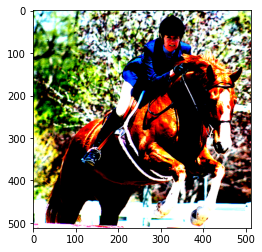

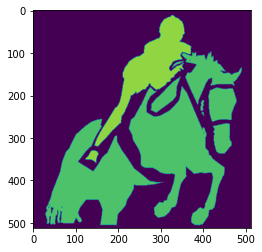

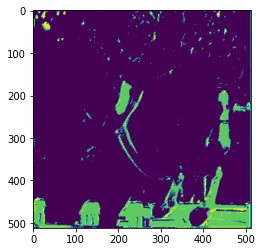

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


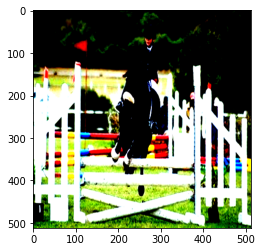

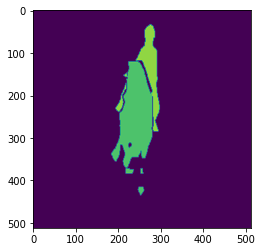

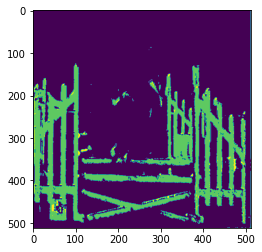

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


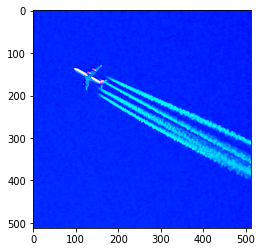

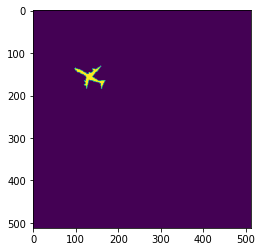

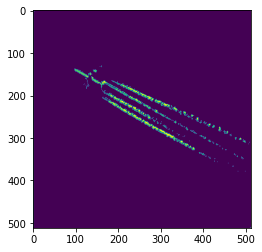

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


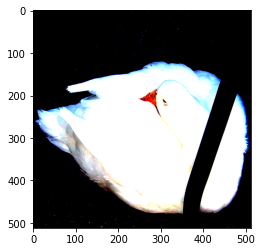

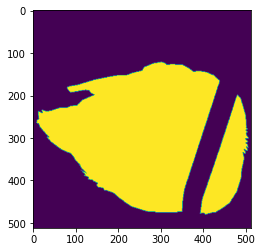

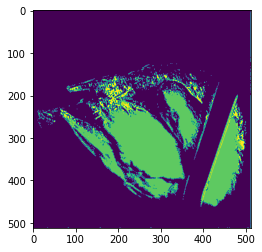

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


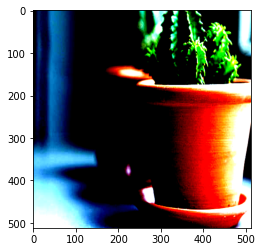

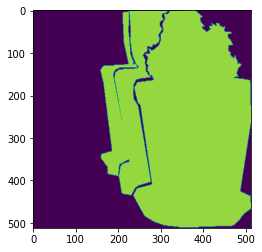

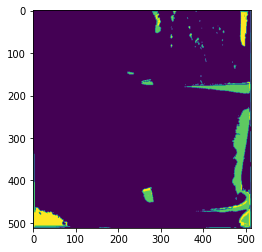

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


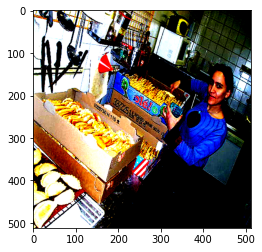

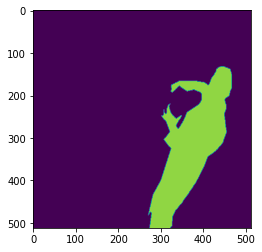

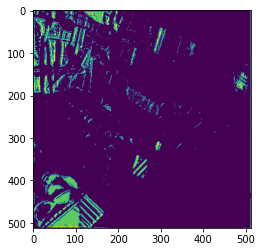

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


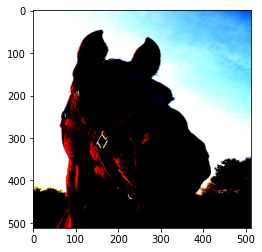

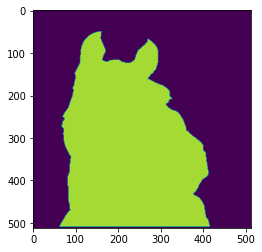

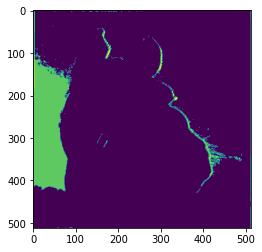

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


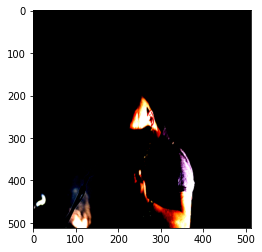

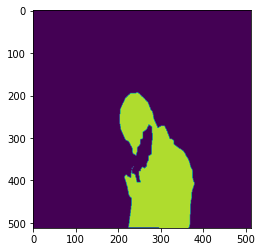

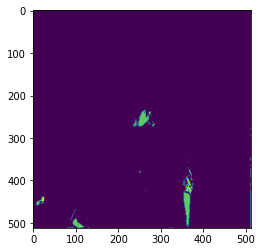

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


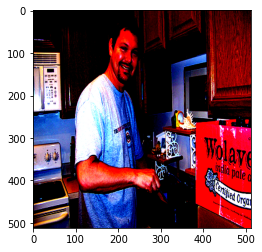

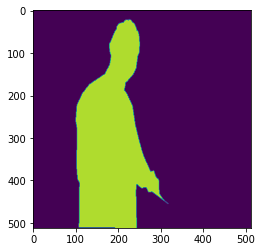

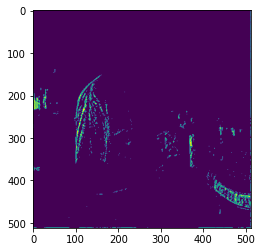

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


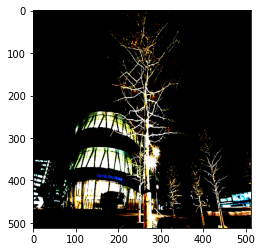

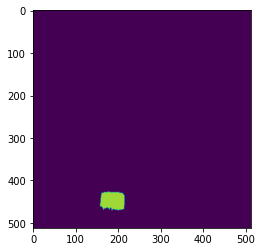

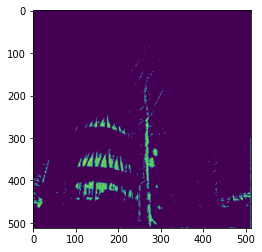

In [ ]:
for i, (d, l) in enumerate(trainloader):
    if i == 10:
        break
    plt.imshow(d.squeeze().transpose(0, 2).transpose(0, 1))
    plt.show()
    
    plt.imshow(l.squeeze())
    plt.show()
    
    plt.imshow(model.classify(d).squeeze())
    plt.show()